# 라이브러리 호출

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchsummary import summary

import torchvision
import torchvision.transforms as transforms  # 데이터 전처리를 위해 사용하는 라이브러리
import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from collections import namedtuple # 튜플의 성질을 갖고 있는 자료형이지만 인덱스뿐만 아니라 키 값으로 데이터에 접근할 수 있음.
import os
import random
import time

import cv2
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Train + train_augumentation

from google.colab import files
from google.colab import drive

drive.mount('/content/drive')

# kaggle 원본 데이터 파일 가져오기.
base_folder_path = '/content/drive/MyDrive/파이썬 기반 딥러닝학습/Data/train'

non_demented_folder = 'NonDemented'
verymild_demented_folder = 'VeryMildDemented'
mild_demented_folder = 'MildDemented'
moderate_demented_folder = 'ModerateDemented'

non_demented_image_filepaths = [os.path.join(base_folder_path, non_demented_folder, f) for f in os.listdir(os.path.join(base_folder_path, non_demented_folder))]
verymild_demented_image_filepaths = [os.path.join(base_folder_path, verymild_demented_folder, f) for f in os.listdir(os.path.join(base_folder_path, verymild_demented_folder))]
mild_demented_image_filepaths = [os.path.join(base_folder_path, mild_demented_folder, f) for f in os.listdir(os.path.join(base_folder_path, mild_demented_folder))]
moderate_demented_image_filepaths = [os.path.join(base_folder_path, moderate_demented_folder, f) for f in os.listdir(os.path.join(base_folder_path, moderate_demented_folder))]

# kaggle 원본 데이터를 데이터 증강(Data Augmentaion) 기법을 통해 증가시킨 데이터 파일 가져오기
base_folder_path2 = '/content/drive/MyDrive/파이썬 기반 딥러닝학습/Data/Data_Augmentaion'

verymild_demented_folder_2 = 'VeryMildDemented' # 768개 증가시켜 -> 2560개로 setting
mild_demented_folder_2 = 'MildDemented' # 1843개 증가시켜 -> 2560개로 setting
moderate_demented_folder_2 = 'ModerateDemented' # 2508개 증가시켜 -> 2560개로 setting

verymild_demented_image_filepaths_2 = [os.path.join(base_folder_path2, verymild_demented_folder_2, f) for f in os.listdir(os.path.join(base_folder_path2, verymild_demented_folder_2))]
mild_demented_image_filepaths_2 = [os.path.join(base_folder_path2, mild_demented_folder_2, f) for f in os.listdir(os.path.join(base_folder_path2, mild_demented_folder_2))]
moderate_demented_image_filepaths_2 = [os.path.join(base_folder_path2, moderate_demented_folder_2, f) for f in os.listdir(os.path.join(base_folder_path2, moderate_demented_folder_2))]

# 모든 이미지 파일 경로를 하나의 리스트로 합칩니다.
images_filepaths = [*non_demented_image_filepaths, *verymild_demented_image_filepaths, *mild_demented_image_filepaths, *moderate_demented_image_filepaths, *verymild_demented_image_filepaths_2, *mild_demented_image_filepaths_2, *moderate_demented_image_filepaths_2]

print("파일 개수: ", len(images_filepaths))

# 이미지 파일을 읽어올 때 유효한 이미지 파일인지 확인합니다.
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
파일 개수:  10240


In [4]:
# Test

test_base_folder_path = '/content/drive/MyDrive/파이썬 기반 딥러닝학습/Data/test'

test_non_demented_folder = 'NonDemented'
test_verymild_demented_folder = 'VeryMildDemented'
test_mild_demented_folder = 'MildDemented'
test_moderate_demented_folder = 'ModerateDemented'

test_non_demented_image_filepaths = [os.path.join(test_base_folder_path, test_non_demented_folder, f) for f in os.listdir(os.path.join(test_base_folder_path, test_non_demented_folder))]
test_verymild_demented_image_filepaths = [os.path.join(test_base_folder_path, test_verymild_demented_folder, f) for f in os.listdir(os.path.join(test_base_folder_path, test_verymild_demented_folder))]
test_mild_demented_image_filepaths = [os.path.join(test_base_folder_path, test_mild_demented_folder, f) for f in os.listdir(os.path.join(test_base_folder_path, test_mild_demented_folder))]
test_moderate_demented_image_filepaths = [os.path.join(test_base_folder_path, test_moderate_demented_folder, f) for f in os.listdir(os.path.join(test_base_folder_path, test_moderate_demented_folder))]

test_images_filepaths = [*test_non_demented_image_filepaths, *test_verymild_demented_image_filepaths, *test_mild_demented_image_filepaths, *test_moderate_demented_image_filepaths]

test_correct_images_filepaths = [i for i in test_images_filepaths if cv2.imread(i) is not None]

In [5]:
print(len(correct_images_filepaths), len(test_correct_images_filepaths)) # train 데이터셋, test 데이터셋 파일 갯수.

10233 1274


In [6]:
random.seed(42)
random.shuffle(correct_images_filepaths)
random.shuffle(test_correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:8186] # 0.8% -> train
val_images_filepaths = correct_images_filepaths[8186:] # 0.2% -> validation
test_images_filepaths = test_correct_images_filepaths

print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths)) # train 데이터셋, validation 데이터셋, test 데이터셋 파일 갯수.

8186 2047 1274


# 이미지 데이터 전처리

In [7]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train' : transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val' : transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

# 변수에 대한 값 정의

In [8]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

# 테스트 이미지 데이터 확인

In [9]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

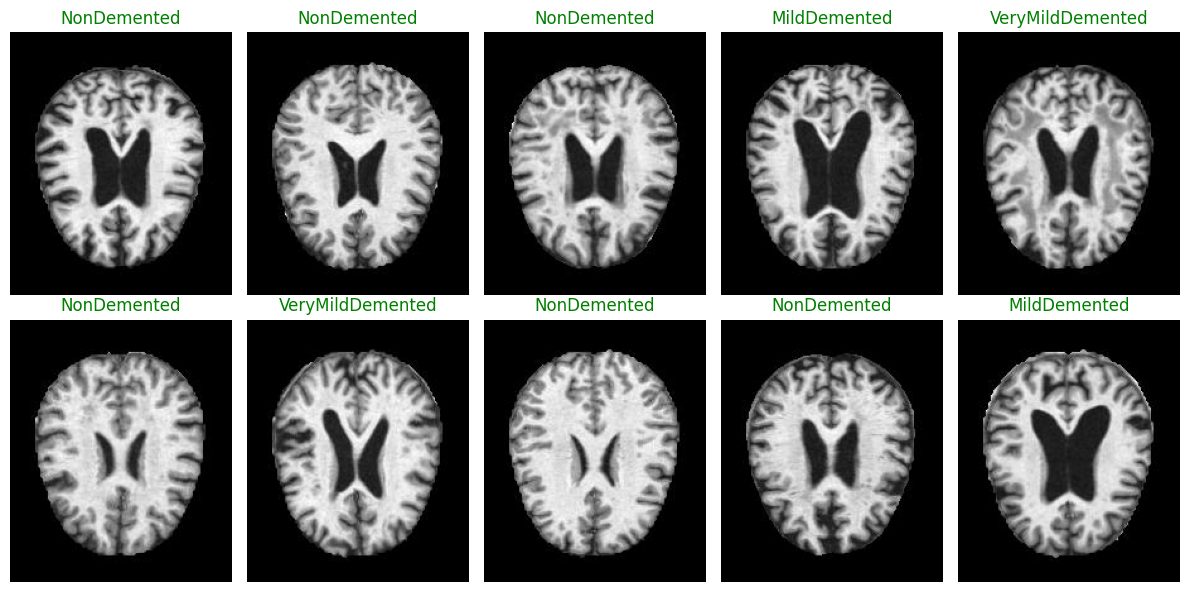

In [10]:
%matplotlib inline

display_image_grid(test_images_filepaths[:10])

# 이미지에 대한 레이블 구분

In [11]:
class alzheimerDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):

        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]

        img = Image.open(img_path).convert('RGB')
        img_transformed = self.transform(img, self.phase)

        label = img_path.split('/')[-1].split('.')[0]
        if label.startswith('nonDem'):
            label = 0
        elif label.startswith('verymildDem'):
            label = 1
        elif label.startswith('mildDem'):
            label = 2
        elif label.startswith('moderateDem'):
            label = 3
        return img_transformed, label

# 이미지 데이터셋 정의

In [12]:
train_dataset = alzheimerDataset(train_images_filepaths,
                                 transform=ImageTransform(size, mean, std),
                                 phase='train')

val_dataset = alzheimerDataset(val_images_filepaths,
                              transform=ImageTransform(size, mean, std),
                              phase='val')

test_dataset = alzheimerDataset(test_images_filepaths,
                              transform=ImageTransform(size, mean, std),
                              phase='val')

index = 0 # index 0의 이미지 크기와 레이블에 대한 출력
print(train_dataset.__getitem__(index)[0].size()) # 이미지는 컬러(채널 3) 상태에서 224 * 224 크기를 갖고 있음.
print(test_dataset.__getitem__(index)[0].size()) # 이미지는 컬러(채널 3) 상태에서 224 * 224 크기를 갖고 있음.
print(train_dataset.__getitem__(index)[1]) # 레이블값 확인 (0, 1, 2, 3 중 하나)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
0


# 데이터셋의 데이터를 메모리로 불러오기

In [13]:
train_iterator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_iterator = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_iterator, 'val': valid_iterator}

batch_iterator = iter(train_iterator)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([0, 1, 3, 3, 3, 1, 3, 2, 3, 2, 1, 0, 0, 1, 2, 1, 1, 1, 3, 2, 0, 1, 2, 1,
        3, 0, 3, 0, 2, 1, 1, 1])


In [15]:
import sys
sys.path.append('/content/drive/MyDrive/파이썬 기반 딥러닝학습')

from ResNet import *

# ResNet50 모델 생성
model = ResNet(resnet101_config, 4)

# 모델 출력 확인
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottlenect(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 학습률 감소

In [15]:
class LRScheduler():
  def __init__(self, optimizer, patience=5, min_lr=1e-6, factor=0.5):
    self.optimizer = optimizer
    self.patience = patience
    self.min_lr = min_lr
    self.factor = factor
    self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        self.optimizer,
        mode='min',
        patience=self.patience,
        factor=self.factor,
        min_lr=self.min_lr,
        verbose=True
    )

  def __call__(self, val_loss):
    self.lr_scheduler.step(val_loss)

# 조기 종료

In [16]:
class EarlyStopping():
  def __init__(self, patience=5, verbose=False, delta=0, path=''):
    self.patience = patience
    self.verbose = verbose
    self.counter = 0
    self.best_score = None
    self.early_stop = False
    self.val_loss_min = np.Inf
    self.delta = delta
    self.path = path

  def __call__(self, val_loss, model):
    score = -val_loss
    if self.best_score is None:
      self.best_score = score
      self.save_checkpoint(val_loss, model)

    elif score < self.best_score + self.delta:
      self.counter += 1
      print(f'EarlyStopping Counter: {self.counter} out of {self.patience}')
      if self.counter >= self.patience:
        self.early_stop = True

    else:
      self.best_score = score
      self.save_checkpoint(val_loss, model)
      self.counter = 0

  def save_checkpoint(self, val_loss, model):
    if self.verbose:
      print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')

    torch.save(model.state_dict(), self.path)
    self.val_loss_min = val_loss

# 옵티마이저와 손실 함수 정의

In [16]:
from torch.optim.lr_scheduler import StepLR

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # 매 10 epoch 마다 학습률을 0.1배로 줄임

In [17]:
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

# 인수 값 지정

In [40]:
parser = argparse.ArgumentParser()
parser.add_argument('--lr-scheduler', dest='lr_scheduler', action='store_true')
parser.add_argument('--early-stopping', dest='early_stoppping', action='store_true')
args = vars(parser.parse_args())

NameError: ignored

# 모델 학습 정확도 측정 함수 정의

In [18]:
def calculate_topk_accuracy(y_pred, y, k=2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, dim=1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim=True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size

    return acc_1, acc_k

# 모델 학습 함수 정의

In [19]:
from torch.nn.functional import one_hot

def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.train()

    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)

        if isinstance(y_pred, (list, tuple)):
            y_pred = y_pred[0]

        y = one_hot(y, num_classes=4)
        y_indices = torch.argmax(y, dim=1)

        loss = criterion(y_pred, y_indices)

        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y_indices)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

# 모델 평가 함수 정의

In [20]:
def evaluate(model, iterator, criterion, device, return_predictions=False):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    valid_labels = []
    valid_probs = []

    model.eval()

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            if isinstance(y_pred, (list, tuple)):
                y_pred = y_pred[0]

            y = one_hot(y, num_classes=4)
            y_indices = torch.argmax(y, dim=1)

            loss = criterion(y_pred, y_indices)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y_indices)

            valid_labels.extend(y.cpu().numpy())
            valid_probs.extend(torch.softmax(y_pred, dim=1).cpu().numpy())

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    if return_predictions:
        return epoch_loss, epoch_acc_1, epoch_acc_5, np.array(valid_labels), np.array(valid_probs)
    else:
        return epoch_loss, epoch_acc_1, epoch_acc_5

# 모델 학습 시간 측정 함수 정의

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time/60)
    elapsed_secs = int(elapsed_time - (elapsed_mins*60))

    return elapsed_mins, elapsed_secs

# 모델 학습

In [22]:
best_valid_loss = float('inf')
EPOCHS = 50
patience = 5  # 성능 개선이 없을 때 얼마나 기다릴지 결정하는 인자
early_stop = 0  # early stopping 카운터

train_accuracy_1 = []
valid_accuracy_1 = []

train_accuracy_5 = []
valid_accuracy_5 = []

train_losses = []
valid_losses = []

for epoch in range(EPOCHS):
    start_time = time.monotonic()

    t_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, device) # train_loss -> t_loss
    v_loss, valid_acc_1, valid_acc_5, valid_labels, valid_preds = evaluate(model, valid_iterator, criterion, device, return_predictions=True) # valid_loss -> v_loss

    train_accuracy_1.append(train_acc_1)
    train_accuracy_5.append(train_acc_5)

    valid_accuracy_1.append(valid_acc_1)
    valid_accuracy_5.append(valid_acc_5)

    train_losses.append(t_loss)
    valid_losses.append(v_loss)

    scheduler.step()

    if v_loss < best_valid_loss:
        best_valid_loss = v_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/파이썬 기반 딥러닝학습/model.pt')
        early_stop = 0
    # 검증 손실이 개선되지 않았다면
    else:
        early_stop += 1
        # 성능 개선이 없는 에폭이 patience보다 크거나 같다면
        if early_stop >= patience:
            print("Early stopping")
            break

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {t_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
         f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {v_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
         f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 2m 49s
	Train Loss: 1.103 | Train Acc @1:  51.31% | Train Acc @5:  79.43%
	Valid Loss: 0.842 | Valid Acc @1:  62.19% | Valid Acc @5:  86.76%
Epoch: 02 | Epoch Time: 2m 52s
	Train Loss: 0.743 | Train Acc @1:  65.87% | Train Acc @5:  90.66%
	Valid Loss: 2.202 | Valid Acc @1:  58.23% | Valid Acc @5:  85.15%
Epoch: 03 | Epoch Time: 2m 52s
	Train Loss: 0.613 | Train Acc @1:  72.06% | Train Acc @5:  94.43%
	Valid Loss: 1.490 | Valid Acc @1:  48.90% | Valid Acc @5:  74.01%
Epoch: 04 | Epoch Time: 2m 53s
	Train Loss: 0.498 | Train Acc @1:  78.12% | Train Acc @5:  96.65%
	Valid Loss: 0.480 | Valid Acc @1:  79.58% | Valid Acc @5:  97.22%
Epoch: 05 | Epoch Time: 2m 51s
	Train Loss: 0.436 | Train Acc @1:  81.01% | Train Acc @5:  97.85%
	Valid Loss: 0.561 | Valid Acc @1:  77.52% | Valid Acc @5:  95.65%
Epoch: 06 | Epoch Time: 2m 51s
	Train Loss: 0.339 | Train Acc @1:  86.02% | Train Acc @5:  98.79%
	Valid Loss: 0.793 | Valid Acc @1:  69.96% | Valid Acc @5:  95.45%
Epoch: 07 

# Train, Validation Data 그래프 확인

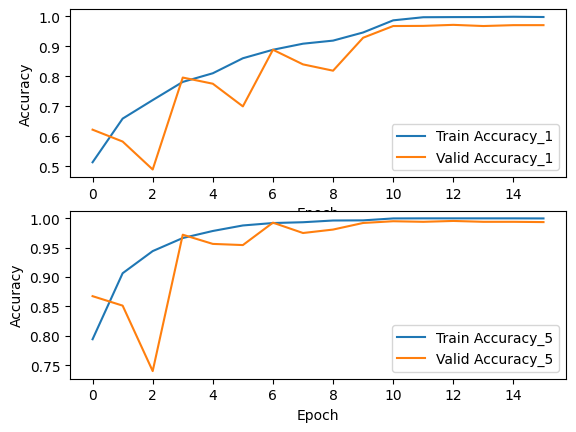

In [23]:
fig, axs = plt.subplots(2)

# 첫 번째 그래프
axs[0].plot(train_accuracy_1, label='Train Accuracy_1')
axs[0].plot(valid_accuracy_1, label='Valid Accuracy_1')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# 두 번째 그래프
axs[1].plot(train_accuracy_5, label='Train Accuracy_5')
axs[1].plot(valid_accuracy_5, label='Valid Accuracy_5')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

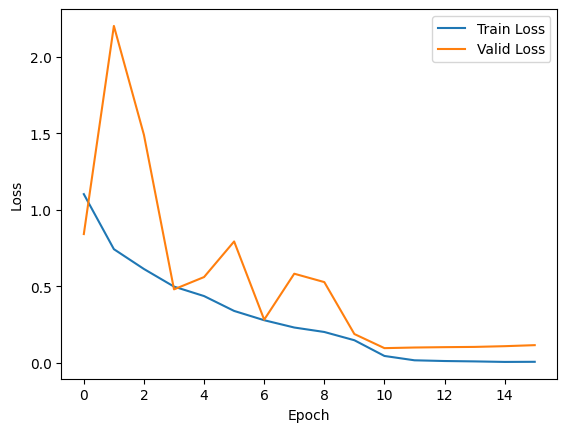

In [24]:
# Plotting train and valid accuracy
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test Data로 Accuracy 확인

In [25]:
class MyDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        x, y = self.dataset[index]
        y = int(y)  # 레이블을 정수로 변환
        if 0 <= y <= 640:
            y = 0  # 'nonDem'
        elif 641 <= y <= 1088:
            y = 1  # 'verymildDem'
        elif 1089 <= y <= 1267:
            y = 2  # 'mildDem'
        elif 1268 <= y <= 1279:
            y = 3  # 'moderateDem'
        return x, y

    def __len__(self):
        return len(self.dataset)

In [26]:
test_dataset = MyDataset(test_dataset)
test_iterator = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict['test'] = test_iterator

batch_iterator = iter(test_iterator)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([0, 0, 0, 2, 1, 0, 1, 0, 0, 2, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 2, 0,
        0, 2, 1, 0, 0, 0, 2, 0])


In [27]:
# 모델 불러오기
model.load_state_dict(torch.load('/content/drive/MyDrive/파이썬 기반 딥러닝학습/model.pt'))

# 모델을 evaluation 모드로 설정
model.eval()

# 테스트 세트에 대한 손실 및 정확도 계산
test_loss, test_acc_1, test_acc_5, test_labels, test_preds = evaluate(model, test_iterator, criterion, device, return_predictions=True)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

Test Loss: 1.596 | Test Acc @1:  57.75% | Test Acc @5:  85.24%
